#Image Classification w/ DL

Lets import all the neccessary libraries and set some variables

In [30]:
#All Imports
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import keras
from keras.applications import InceptionV3

# Unzip after uploading
# %reset
# !unzip '/content/cards/data.zip'
# !rm -rf '/content/__MACOSX'

#Constants:
batch_size = 40
image_size = (224,224)
num_classes = 4
epochs = 10


#Create Sets

We are going to try to compare models in their ability to classify playing cards by suit

So we start by creating the train and test sets, and show a few examples of the types of images in the set.

Found 8024 files belonging to 4 classes.
Using 6420 files for training.
Using 1604 files for validation.
['Club', 'Diamond', 'Heart', 'Spade']


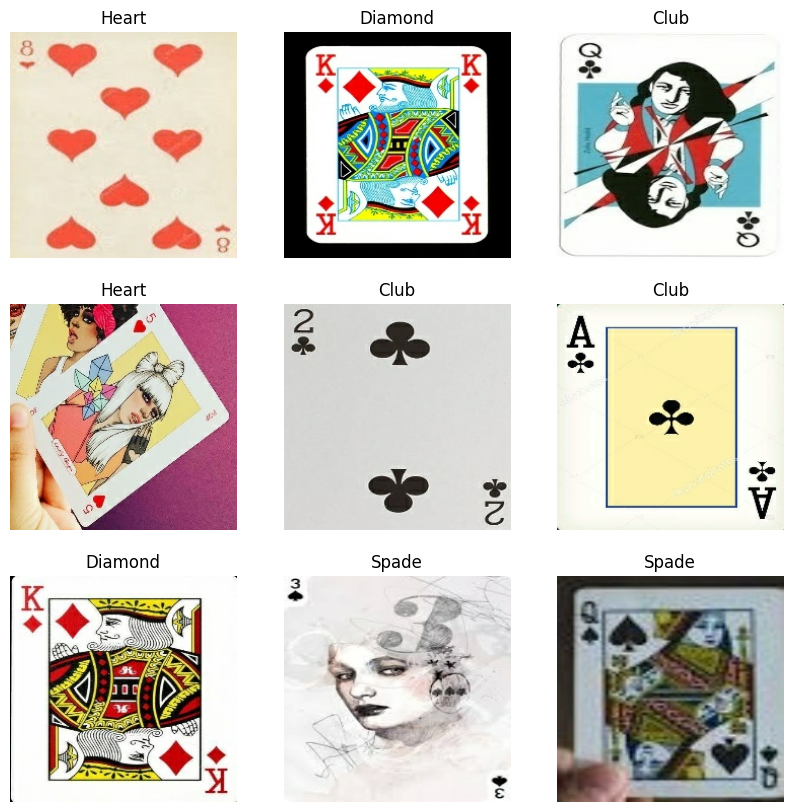

In [26]:

#Create train and test sets
train_data, test_data = tf.keras.utils.image_dataset_from_directory('/content/data/', shuffle = True, batch_size = batch_size, image_size = image_size, seed = 1234, validation_split=0.2, subset='both', label_mode='categorical')

#Check the inferred classes
class_names = train_data.class_names
print(class_names)

#Found at [https://www.tensorflow.org/tutorials/images/transfer_learning]
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #print(list((labels[i].numpy().astype('int'))).index(1))
    plt.title(class_names[list((labels[i].numpy().astype('int'))).index(1)])
    plt.axis("off")

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)




#Sequential Model

This is the a normal Sequential Model

In [4]:
sequential = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

sequential.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

sequential.summary()

history_sequential = sequential.fit(
    train_data,
    epochs = epochs,
    steps_per_epoch = 15,
    batch_size = batch_size,
    validation_data = test_data
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_3 (Dense)             (None, 512)               77070848  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 77,335,556
Trainable params: 77,335,556


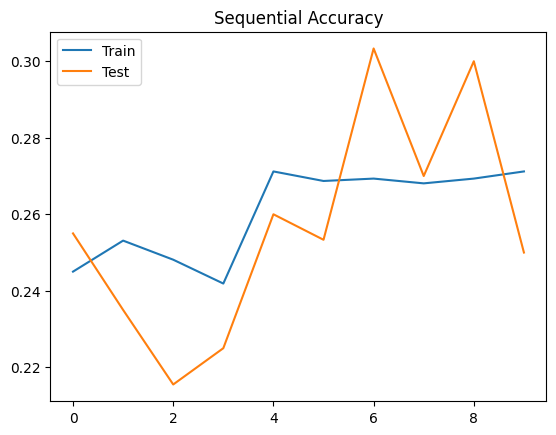

In [5]:
plt.plot(history_sequential.history['val_accuracy'])
plt.plot(history_sequential.history['accuracy'])
plt.title('Sequential Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

The fact that accuracy goes up and down means the learning rate is too high.

#CNN Model

In [8]:
cnn = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

cnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

cnn.summary()

history_cnn = cnn.fit(
    train_data,
    epochs = epochs,
    steps_per_epoch = 15,
    batch_size = batch_size,
    validation_data = test_data
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 93312)             0         
                                                                 
 dropout_6 (Dropout)         (None, 93312)            

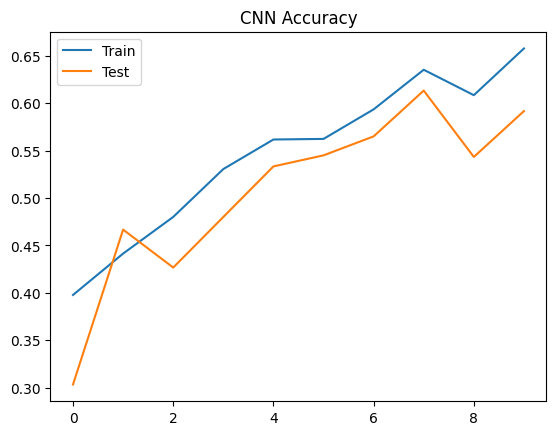

In [36]:
plt.plot(history_cnn.history['val_accuracy'])
plt.plot(history_cnn.history['accuracy'])
plt.title('CNN Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

#Pre-trained Model

In [34]:
pre_trained = InceptionV3(weights = 'imagenet', classes = num_classes, include_top = False, input_shape=(224,224,3))

for layer in pre_trained.layers:
  layer.trainable = False

inception = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3)),
    pre_trained,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

inception.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

inception.summary()

history_inception = inception.fit(
    train_data,
    epochs = epochs,
    steps_per_epoch = 15,
    batch_size = batch_size,
    validation_data = test_data
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 51200)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               26214912  
                                                                 
 batch_normalization_282 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                      

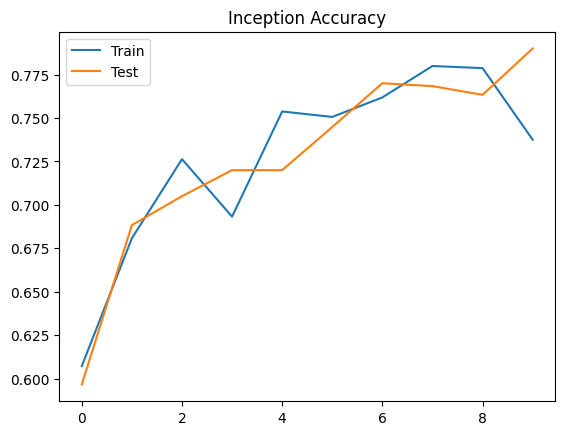

In [35]:
plt.plot(history_inception.history['val_accuracy'])
plt.plot(history_inception.history['accuracy'])
plt.title('Inception Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

I was going to take a picture of one of the playing cards I have at home, and see if the model would accurately classify it, but I ran out of time.

#Analysis

The 3 models used have very different levels of accuracy:

- Normal Sequential: ~25% accuracy
- CNN: ~59% accuracy
- Pre-Trained Model: ~79% accuracy

So just by glance, it would seem the Pre-Trained Model is the best, especially getting that accurate with the relatively small dataset given. However it also took significantly longer to train compared to the others. In general it seems that the cost of getting a more accurate model, tends to be an increase in training time.